Download data

In [0]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip
!ls

--2019-07-26 16:41:56--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.2.116, 13.224.2.123, 13.224.2.121, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.2.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  --.-KB/s    in 0.08s   

2019-07-26 16:41:56 (35.4 MB/s) - ‘data.zip.1’ saved [2882130/2882130]

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  in

In [0]:
%matplotlib inline


Generating Names with a Character-Level RNN
*******************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

In the :doc:`last tutorial </intermediate/char_rnn_classification_tutorial>`
we used a RNN to classify names into their language of origin. This time
we'll turn around and generate names from languages.

::

    > python sample.py Russian RUS
    Rovakov
    Uantov
    Shavakov

    > python sample.py German GER
    Gerren
    Ereng
    Rosher

    > python sample.py Spanish SPA
    Salla
    Parer
    Allan

    > python sample.py Chinese CHI
    Chan
    Hang
    Iun

We are still hand-crafting a small RNN with a few linear layers. The big
difference is instead of predicting a category after reading in all the
letters of a name, we input a category and output one letter at a time.
Recurrently predicting characters to form language (this could also be
done with words or other higher order constructs) is often referred to
as a "language model".

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  http://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

I also suggest the previous tutorial, :doc:`/intermediate/char_rnn_classification_tutorial`


Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

See the last tutorial for more detail of this process. In short, there
are a bunch of plain text files ``data/names/[Language].txt`` with a
name per line. We split lines into an array, convert Unicode to ASCII,
and end up with a dictionary ``{language: [names ...]}``.




In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import math
import random

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
train_data = {}
test_data = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    train_data[category] = lines[0:int(math.floor(0.8*len(lines)))]
    test_data[category] = lines[int(math.floor(0.8*len(lines)))+1:]
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['German', 'Arabic', 'Vietnamese', 'Greek', 'French', 'Scottish', 'Italian', 'Chinese', 'Korean', 'Russian', 'Dutch', 'Japanese', 'Polish', 'English', 'Irish', 'Czech', 'Spanish', 'Portuguese']
O'Neal


Creating the Network
====================

This network extends `the last tutorial's RNN <#Creating-the-Network>`__
with an extra argument for the category tensor, which is concatenated
along with the others. The category tensor is a one-hot vector just like
the letter input.

We will interpret the output as the probability of the next letter. When
sampling, the most likely output letter is used as the next input
letter.

I added a second linear layer ``o2o`` (after combining hidden and
output) to give it more muscle to work with. There's also a dropout
layer, which `randomly zeros parts of its
input <https://arxiv.org/abs/1207.0580>`__ with a given probability
(here 0.1) and is usually used to fuzz inputs to prevent overfitting.
Here we're using it towards the end of the network to purposely add some
chaos and increase sampling variety.

.. figure:: https://i.imgur.com/jzVrf7f.png
   :alt:





In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

Training
=========
Preparing for Training
----------------------

First of all, helper functions to get random pairs of (category, line):




In [0]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(train_data[category])
    return category, line

For each timestep (that is, for each letter in a training word) the
inputs of the network will be
``(category, current letter, hidden state)`` and the outputs will be
``(next letter, next hidden state)``. So for each training set, we'll
need the category, a set of input letters, and a set of output/target
letters.

Since we are predicting the next letter from the current letter for each
timestep, the letter pairs are groups of consecutive letters from the
line - e.g. for ``"ABCD<EOS>"`` we would create ("A", "B"), ("B", "C"),
("C", "D"), ("D", "EOS").

.. figure:: https://i.imgur.com/JH58tXY.png
   :alt:

The category tensor is a `one-hot
tensor <https://en.wikipedia.org/wiki/One-hot>`__ of size
``<1 x n_categories>``. When training we feed it to the network at every
timestep - this is a design choice, it could have been included as part
of initial hidden state or some other strategy.




In [0]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)
  
# mm = targetTensor('Faerber')
# mm.size()
# mm.unsqueeze_(-1)

For convenience during training we'll make a ``randomTrainingExample``
function that fetches a random (category, line) pair and turns them into
the required (category, input, target) tensors.




In [22]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor
  
randomTrainingExample()

(tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Training the Network
--------------------

In contrast to classification, where only the last output is used, we
are making a prediction at every step, so we are calculating loss at
every step.

The magic of autograd allows you to simply sum these losses at each step
and call backward at the end.




In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

To keep track of how long training takes I am adding a
``timeSince(timestamp)`` function which returns a human readable string:




In [0]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

Training is business as usual - call train a bunch of times and wait a
few minutes, printing the current time and loss every ``print_every``
examples, and keeping store of an average loss per ``plot_every`` examples
in ``all_losses`` for plotting later.




In [0]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
all_test_losses = []
total_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_test_losses.append(total_test_loss / n_test_instances)


1m 3s (5000 5%) 2.4825
2m 12s (10000 10%) 3.3082
3m 21s (15000 15%) 2.0799
4m 30s (20000 20%) 2.0315
5m 39s (25000 25%) 2.7411
6m 50s (30000 30%) 3.0812
8m 1s (35000 35%) 2.3483
9m 12s (40000 40%) 2.0523
10m 23s (45000 45%) 3.1864
11m 32s (50000 50%) 1.5599
12m 43s (55000 55%) 2.1057
13m 55s (60000 60%) 2.5501
15m 7s (65000 65%) 2.4551
16m 18s (70000 70%) 1.6869
17m 30s (75000 75%) 2.4009
18m 40s (80000 80%) 3.1876
19m 50s (85000 85%) 2.9766
21m 2s (90000 90%) 1.4932
22m 10s (95000 95%) 3.3935
23m 20s (100000 100%) 2.2985


Plotting the Losses
-------------------

Plotting the historical loss from all\_losses shows the network
learning:




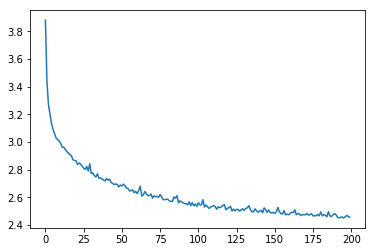

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_test_losses)

Sampling the Network
====================

To sample we give the network a letter and ask what the next one is,
feed that in as the next letter, and repeat until the EOS token.

-  Create tensors for input category, starting letter, and empty hidden
   state
-  Create a string ``output_name`` with the starting letter
-  Up to a maximum output length,

   -  Feed the current letter to the network
   -  Get the next letter from highest output, and next hidden state
   -  If the letter is EOS, stop here
   -  If a regular letter, add to ``output_name`` and continue

-  Return the final name

.. Note::
   Rather than having to give it a starting letter, another
   strategy would have been to include a "start of string" token in
   training and have the network choose its own starting letter.




In [0]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovell
Uanter
Shavaki
Garter
Ering
Rour
Santeran
Paner
Allan
Cha
Han
Iuan


Exercises
=========

-  Try with a different dataset of category -> line, for example:

   -  Fictional series -> Character name
   -  Part of speech -> Word
   -  Country -> City

-  Use a "start of sentence" token so that sampling can be done without
   choosing a start letter
-  Get better results with a bigger and/or better shaped network

   -  Try the nn.LSTM and nn.GRU layers
   -  Combine multiple of these RNNs as a higher level network




**Q1b) ii**

previous hidden unit and previous
character

category as input to the hidden unit(s) of the
first time steps only

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN_ii(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_ii, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, i, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        output = self.i2o(input_combined)
        
        if (i != 0):
          category = torch.zeros(1, n_categories)
          input_combined = torch.cat((category, input, hidden), 1)
        
        hidden = self.i2h(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train_ii(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_ii.initHidden()

    rnn_ii.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn_ii(i, category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn_ii.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [41]:
rnn_ii = RNN_ii(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
all_test_losses_ii = []
total_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate_ii(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_ii.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn_ii(i, category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train_ii(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate_ii(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_test_losses_ii.append(total_test_loss / n_test_instances)


1m 1s (5000 5%) 3.1880
2m 7s (10000 10%) 2.9047
3m 14s (15000 15%) 2.9780
4m 20s (20000 20%) 3.0054
5m 26s (25000 25%) 2.5310
6m 31s (30000 30%) 2.3442
7m 37s (35000 35%) 2.5306
8m 43s (40000 40%) 2.6116
9m 48s (45000 45%) 2.3360
10m 53s (50000 50%) 2.1874
11m 57s (55000 55%) 2.4568
13m 2s (60000 60%) 3.0485
14m 7s (65000 65%) 2.1222
15m 12s (70000 70%) 2.5670
16m 17s (75000 75%) 2.9971
17m 21s (80000 80%) 2.2836
18m 27s (85000 85%) 2.6741
19m 31s (90000 90%) 1.7688
20m 35s (95000 95%) 2.6204
21m 39s (100000 100%) 2.8685


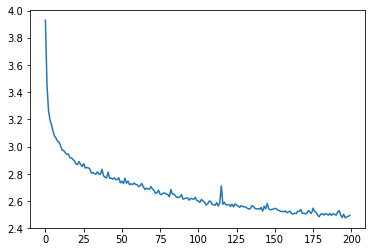

In [42]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_test_losses_ii)

**Q1b) iii**

previous hidden unit and category

avoid feeding the previous character

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN_iii(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_iii, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        input_combined_h = torch.cat((category, hidden), 1)
        output = self.i2o(input_combined)
        hidden = self.i2h(input_combined_h)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train_iii(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_iii.initHidden()

    rnn_iii.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn_iii(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn_iii.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [46]:
rnn_iii = RNN_iii(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
all_test_losses_iii = []
total_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate_iii(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_iii.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn_iii(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train_iii(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate_iii(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_test_losses_iii.append(total_test_loss / n_test_instances)


0m 59s (5000 5%) 3.6677
2m 3s (10000 10%) 2.2913
3m 7s (15000 15%) 2.5794
4m 11s (20000 20%) 2.5878
5m 14s (25000 25%) 1.7425
6m 17s (30000 30%) 2.2365
7m 20s (35000 35%) 2.5314
8m 23s (40000 40%) 1.8905
9m 26s (45000 45%) 2.6223
10m 29s (50000 50%) 2.4311
11m 32s (55000 55%) 1.9980
12m 36s (60000 60%) 2.5377
13m 38s (65000 65%) 3.0232
14m 40s (70000 70%) 1.8133
15m 42s (75000 75%) 3.0313
16m 44s (80000 80%) 3.1245
17m 46s (85000 85%) 1.6413
18m 48s (90000 90%) 2.5387
19m 50s (95000 95%) 2.1899
20m 51s (100000 100%) 3.2101


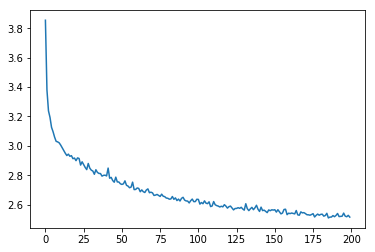

In [47]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_test_losses_iii)

**Q1b) iv**

previous hidden unit 

category as input to the hidden unit(s) of the
first time steps only

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN_iv(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_iv, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, i, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        output = self.i2o(input_combined)
        input_combined_h = torch.cat((category, hidden), 1)

        if (i != 0):
          category = torch.zeros(1, n_categories)
          input_combined_h = torch.cat((category, hidden), 1)
        
        hidden = self.i2h(input_combined_h)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train_iv(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_iv.initHidden()

    rnn_iv.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn_iv(i, category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn_iv.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [67]:
rnn_iv = RNN_iv(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
all_test_losses_iv = []
total_loss = 0 # Reset every plot_every iters

# Just return an output given a line
def evaluate_iv(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn_iv.initHidden()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn_iv(i, category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
    return output, loss.item() / input_line_tensor.size(0)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train_iv(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
        
    # Compute loss based on test data
    if iter % plot_every == 0:
        total_test_loss = 0
        n_test_instances = 0
        for category in all_categories:
            category_tensor = Variable(categoryTensor(category))
            n_test_instances = n_test_instances + len(test_data[category])
            for line in test_data[category]:
                input_line_tensor = Variable(inputTensor(line))
                target_line_tensor = Variable(targetTensor(line))
                output, test_loss = evaluate_iv(category_tensor, input_line_tensor, target_line_tensor)
                total_test_loss += test_loss
        all_test_losses_iv.append(total_test_loss / n_test_instances)


1m 0s (5000 5%) 3.0208
2m 6s (10000 10%) 3.0891
3m 11s (15000 15%) 2.4880
4m 16s (20000 20%) 3.9480
5m 21s (25000 25%) 2.5302
6m 26s (30000 30%) 2.9247
7m 31s (35000 35%) 2.9522
8m 36s (40000 40%) 2.6199
9m 41s (45000 45%) 3.1043
10m 45s (50000 50%) 1.9010
11m 50s (55000 55%) 2.8574
12m 55s (60000 60%) 2.3905
13m 59s (65000 65%) 3.0329
15m 4s (70000 70%) 1.9981
16m 8s (75000 75%) 2.5194
17m 14s (80000 80%) 2.2066
18m 18s (85000 85%) 3.1136
19m 22s (90000 90%) 2.6394
20m 26s (95000 95%) 2.7978
21m 30s (100000 100%) 2.0795


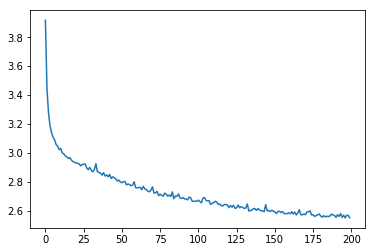

In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_test_losses_iv)

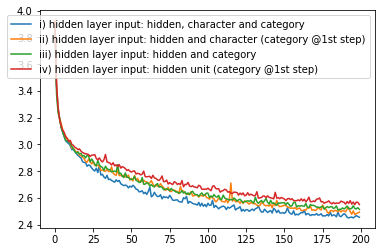

In [70]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_test_losses, label = 'i) hidden layer input: hidden, character and category' )
plt.plot(all_test_losses_ii, label = 'ii) hidden layer input: hidden and character (category @1st step)')
plt.plot(all_test_losses_iii, label = 'iii) hidden layer input: hidden and category')
plt.plot(all_test_losses_iv, label = 'iv) hidden layer input: hidden unit (category @1st step)')
plt.legend()

#### Result discussion

As can be seen from the graphs above, the more information in the input, the better the performance. The best berformance is for the model which gets all information including; previous hidden unit, previous character and category (model 1). Then the models wich get two inputs (model ii & iii) come next. The worst performance is for model iv which just get the previous unit hidden state.  